In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow')))

In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import scipy
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

In [3]:
import tensorflow_datasets as tfds
from skimage.util import random_noise
from tensorflow.keras.utils import to_categorical
from tensorflow_probability import distributions as tfd

2023-06-08 18:58:16.796209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 18:58:19.671259: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-06-08 18:58:19.671400: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [4]:
import tensorflow as tf
import bayesflow as bf

In [5]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D

# Set up Forward Inference

In [6]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [7]:
forward_train = {
    'prior_draws': train_images,
    'sim_data': train_images
}

num_val = 500
perm = np.random.default_rng(seed=42).permutation(test_images.shape[0])

forward_val = {
    'prior_draws': test_images[perm[:num_val]],
    'sim_data': test_images[perm[:num_val]],
}

forward_test = {
    'prior_draws': test_images[perm[num_val:]],
    'sim_data': test_images[perm[num_val:]],
}

val_labels = test_labels[perm[:num_val]]
test_labels = test_labels[perm[num_val:]]

In [8]:
def grayscale_camera(theta, noise="poisson", psf_width=2.5, noise_scale=1, noise_gain=0.5):
    """Creates a noisy blurred image.
    
    Parameters:
    ----------
    theta       : input image to be blurred.
    noise       : noise type.
    psf_width   : width of point-spread function.
    noise_scale : scale for noise distribution.
    noise_gain  : gain for noise distribution.
    """
    
    image1 = noise_gain * random_noise(noise_scale * theta, mode=noise)
    image2 = gaussian_filter(image1, sigma=psf_width)
    return image2

# Configurator

In [9]:
def configurator(f):
    
    out = {}
    
    B = f['prior_draws'].shape[0]
    H = f['prior_draws'].shape[1]
    W = f['prior_draws'].shape[2]
    
    # Normalize image between -1 and 1
    p = (f['prior_draws']).reshape(B, H*W).astype(np.float32)
    p = -1. + (p * 2) / 255. 
    
    # Add blurr
    blurred = np.stack([grayscale_camera(f['sim_data'][b]) for b in range(B)]).astype(np.float32)[..., None]
    
    # Add some noise to "parameters" for stability
    p += 1e-3 * np.random.normal(size=p.shape)
    
    out['parameters'] = p
    out['summary_conditions'] = blurred
    return out

# Sanity Check

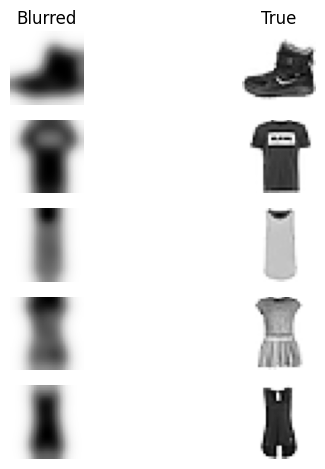

In [10]:
how_many = 5
conf = configurator({
    'sim_data': forward_train['sim_data'][:how_many],
    'prior_draws': forward_train['prior_draws'][:how_many],
})

f, axarr = plt.subplots(how_many, 2)
for i in range(how_many):
    if i == 0:
        axarr[i, 0].set_title('Blurred')
        axarr[i, 1].set_title('True')
    axarr[i, 0].imshow(conf['summary_conditions'][i, :, :, 0], cmap=plt.cm.get_cmap('Greys'))
    axarr[i, 1].imshow(conf['parameters'][i].reshape(28, 28), cmap=plt.cm.get_cmap('Greys'))
    axarr[i, 0].axis('off')
    axarr[i, 1].axis('off')
f.tight_layout()

# Set up Amortizers

In [11]:
summary_network = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters=64, 
        kernel_size=(3, 3), 
        activation='relu', 
        kernel_initializer='he_normal', 
        input_shape=(28, 28, 1), 
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(
        filters=64, 
        kernel_size=(3, 3), 
        activation='relu', 
        kernel_initializer='he_normal', 
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(
        filters=128, 
        kernel_size=(3, 3), 
        activation='relu', 
        kernel_initializer='he_normal', 
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(
        filters=128, 
        kernel_size=(3, 3), 
        activation='relu', 
        kernel_initializer='he_normal', 
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D()
])

2023-06-08 18:58:25.828759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-08 18:58:25.841793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-08 18:58:25.843602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-08 18:58:25.845825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [12]:
coupling_settings = {
    "dense_args": dict(units=512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    "num_dense": 1,
    "dropout_prob": 0.15
}

posterior_net = bf.networks.InvertibleNetwork(
    num_params=int(28*28),
    num_coupling_layers=12,
    coupling_settings=coupling_settings
)

dim = int(28*28)
loc = [0.]*dim
scale = tf.linalg.LinearOperatorDiag([1.]*dim)
latent_dist = tfd.MultivariateStudentTLinearOperator(df=100, loc=loc, scale=scale)

amortizer = bf.amortizers.AmortizedPosterior(
    posterior_net, summary_net=summary_network, latent_dist=latent_dist, summary_loss_fun='MMD')

# Trainer definition

In [13]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    checkpoint_path='checkpoint/posterior',
    configurator=configurator,
    memory=False,
    default_lr=1e-3,
    max_to_keep=1
)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Loaded loss history from checkpoint/posterior/history_150.pkl.
INFO:root:Networks loaded from checkpoint/posterior/ckpt-150


## Offline Training
Uncomment for training.

In [14]:
# h = trainer.train_offline(forward_train, epochs=150, batch_size=32, validation_sims=forward_val)

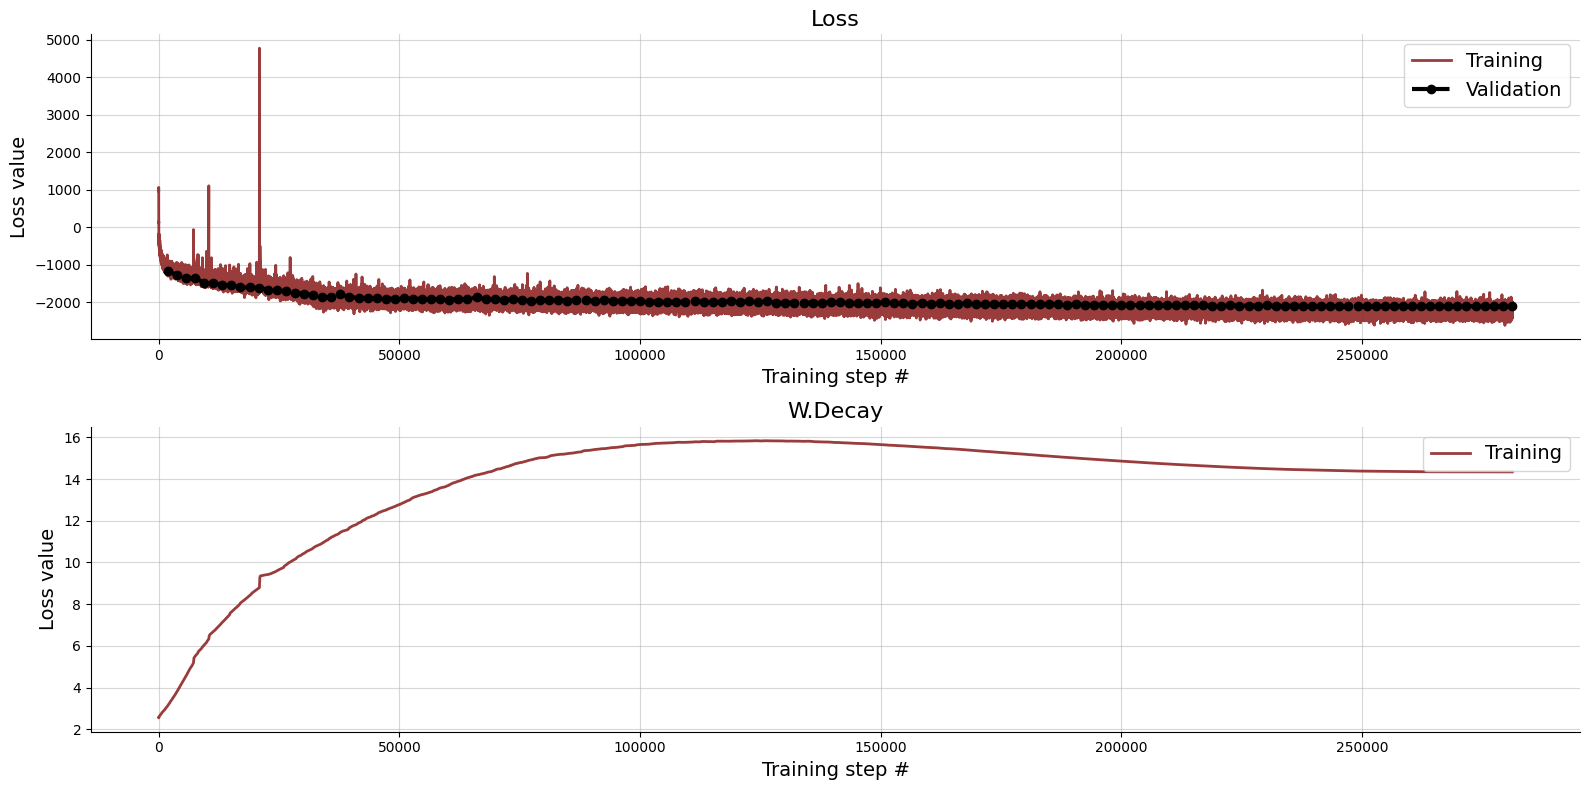

In [17]:
h = trainer.loss_history.get_plottable()
f = bf.diagnostics.plot_losses(h['train_losses'], h['val_losses'])

# Validation

In [27]:
plt.rcParams.update({
    "axes.labelsize" : 24,
    "xtick.labelsize" : 16,
    "ytick.labelsize" : 16,
    "legend.fontsize": 24,
    "text.usetex": False,
    "font.family": "serif",
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

In [28]:
conf = configurator(forward_test)

## Per-Class Generation

In [97]:
class_names = [
    'T-Shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'
]

y_labels = [r'Parameter $\theta$', r'Observation $x$', 'Mean', 'Std.Dev']

In [98]:
def random_indices_per_class(labels, seed=42):
    out = {}
    unique = np.unique(labels)
    perm = np.random.default_rng(seed).permutation(labels.shape[0])
    for i in unique:
        for idx in perm:
            if i == labels[idx]:
                out[i] = idx
                break
    return out

## Means and STDs

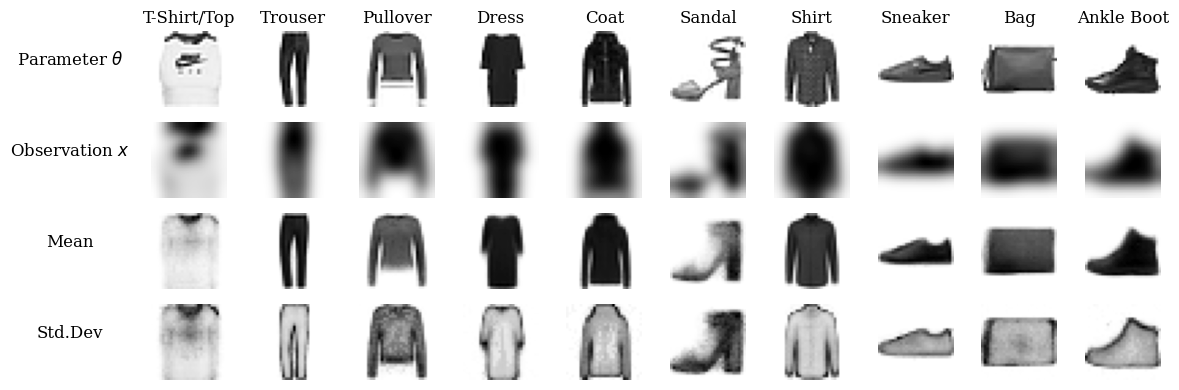

In [99]:
idx_dict = random_indices_per_class(test_labels, seed=42)
n_samples = 250
f, axarr = plt.subplots(4, len(idx_dict), figsize=(12, 4))
for i, (c, idx) in enumerate(idx_dict.items()):
    
    # Prepare input dict for network
    inp = {
        'parameters': conf['parameters'][idx:(idx+1)],
        'summary_conditions': conf['summary_conditions'][idx:(idx+1)],
    }
    
    # Obtain samples
    samples = np.clip(amortizer.sample(inp, n_samples), -1.0, 1.0)
    
    # Plot truth and blurred
    axarr[0, i].imshow(inp['parameters'].reshape((28, 28, 1)), cmap=plt.cm.get_cmap('binary'))
    axarr[1, i].imshow(inp['summary_conditions'].reshape((28, 28, 1)), cmap=plt.cm.get_cmap('binary'))
    axarr[2, i].imshow(samples.mean(0).reshape(28, 28, 1), cmap=plt.cm.get_cmap('binary'))
    axarr[3, i].imshow(samples.std(0).reshape(28, 28, 1), cmap=plt.cm.get_cmap('binary'))
    
    axarr[0, i].set_title(class_names[i])
    
for j, label in enumerate(y_labels):   
    axarr[j, 0].set_ylabel(label, rotation=0, labelpad=55, fontsize=12)
            
# get rid of axis
for ax in axarr.flat:
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
f.tight_layout()

In [100]:
f.savefig('figures/denoising_main.pdf', dpi=300, bbox_inches='tight')

# Calibration

In [88]:
# Prepare input dict for networks
posterior_conds = tf.split(conf['summary_conditions'], 100)
posterior_inputs = [{'summary_conditions': c} for c in posterior_conds]

post_samples = amortizer.sample_loop(posterior_inputs, n_samples=100)

## Numeric

In [55]:
cal_errs = bf.computational_utilities.posterior_calibration_error(post_samples, conf['parameters'])

Text(0.5, 0, 'Median Calibration Error')

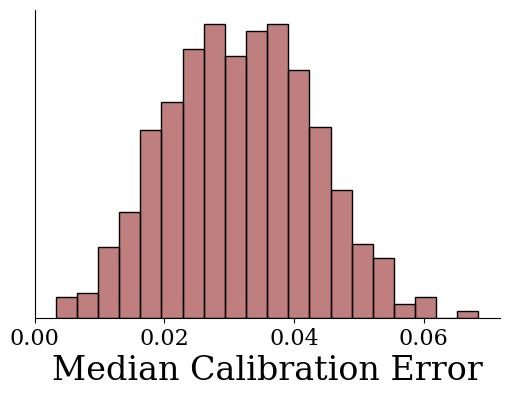

In [101]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.histplot(cal_errs, bins=20, color='maroon', alpha=0.5, ax=ax)
sns.despine(ax=ax)
ax.set_ylabel('')
ax.set_yticks([])
ax.set_xlabel('Median Calibration Error')

In [104]:
print('Mean calibration error: ', np.mean(cal_errs))
print('SD of calibration error: ', np.std(cal_errs))

Mean calibration error:  0.03183425080558538
SD of calibration error:  0.011229284534221493


## Visual
Pick random 1000 data sets and 64 pixels.

In [93]:
# Extract 1000 random test images
to_plot_datasets = np.random.default_rng(42).permutation(conf['parameters'].shape[0])[:1000]
to_plot_pixels = np.random.default_rng(42).permutation(conf['parameters'].shape[1])[:64]
post_samples_plot = post_samples[to_plot_datasets]
ground_truths_plot = conf['parameters'][to_plot_datasets]
post_samples_plot = post_samples_plot[:, :, to_plot_pixels]
ground_truths_plot = ground_truths_plot[:, to_plot_pixels]

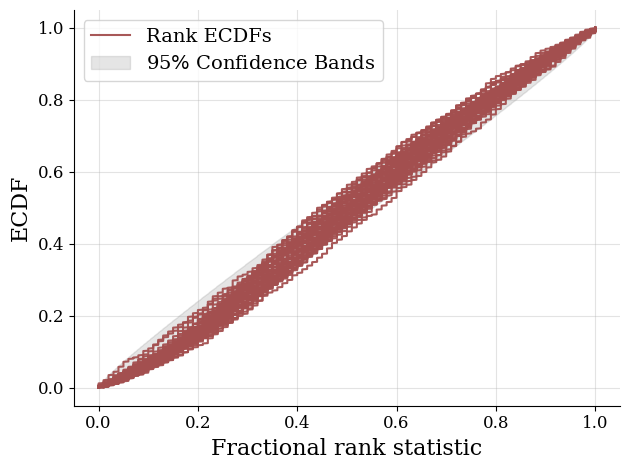

In [94]:
f = bf.diagnostics.plot_sbc_ecdf(post_samples_plot, ground_truths_plot, stacked=True)